In [39]:
import os
# change the path to the root of the project directory if not in "project-5" directory
while os.path.basename(os.getcwd()) != "project-5":
    os.chdir("..")
print(f"Current working directory: {os.getcwd()}")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.model_runner import evaluate_models, plot_roc_curves, plot_precision_recall_curves, plot_classification_metric
from src.utils.data_handler import DataHandler
from sklearn.feature_selection import SelectKBest, f_classif

DH = DataHandler()

Current working directory: /home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5


<h1>Load GE and PFS</h1>

In [40]:
df_sig = pd.read_csv('/home/chris/code/ucsd/beng285/breast-cancer-team-1/project-5/data/raw/SBS96_S4_NMF_Activities.txt', sep='\t', index_col=0)

metadata = pd.read_csv('data/raw/brca_tcga_pan_can_atlas_2018_clinical_data_PAM50_subype_and_progression_free_survival.tsv', sep='\t', index_col=[1,2])
pfs = metadata['Progress Free Survival (Months)']
# drop sample id column
pfs = pfs.reset_index().drop(columns='Sample ID').set_index('Patient ID')

n_patients = df_sig.index.nunique()
n_samples = df_sig.shape[0]
print(f"There are {n_patients} patients and {n_samples} samples in the dataset.")

There are 789 patients and 789 samples in the dataset.


<h1>Generate X and y</h1>

In [60]:
X = df_sig.copy()

# remove samples with nan pfs values
pfs = pfs.dropna()

# get intersection of samples in X and pfs
intersection_samples = X.index.intersection(pfs.index)
print(f"Number of samples in intersection: {len(intersection_samples)}")

# filter to keep only samples in the intersection
X = X.loc[intersection_samples]
pfs = pfs.loc[intersection_samples]

# convert X to log1p
X_log1p = np.log1p(X)

# get bool of whether pfs is greater than 5 years
y = pfs > 5 * 12 
y = list(y['Progress Free Survival (Months)'])

Number of samples in intersection: 782


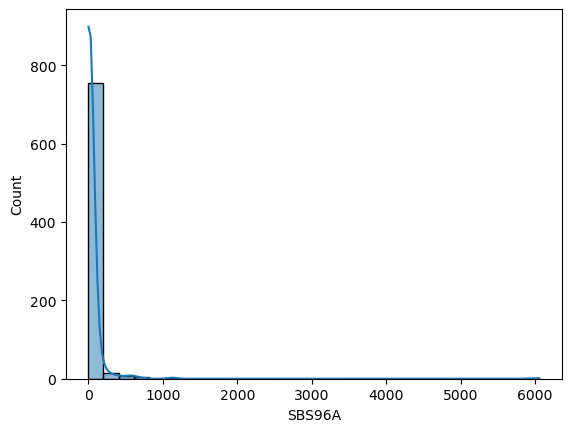

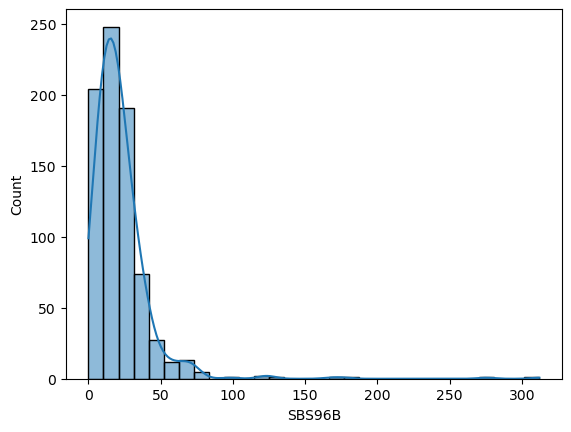

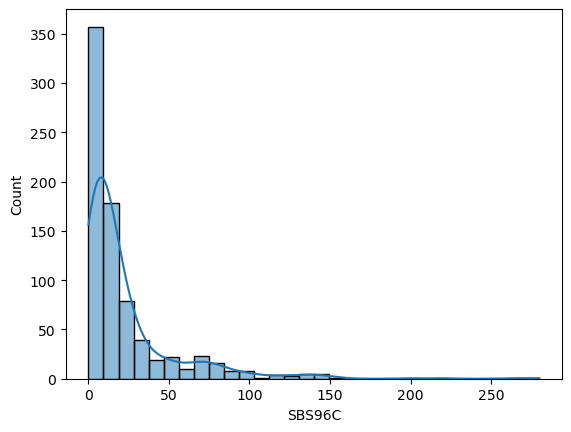

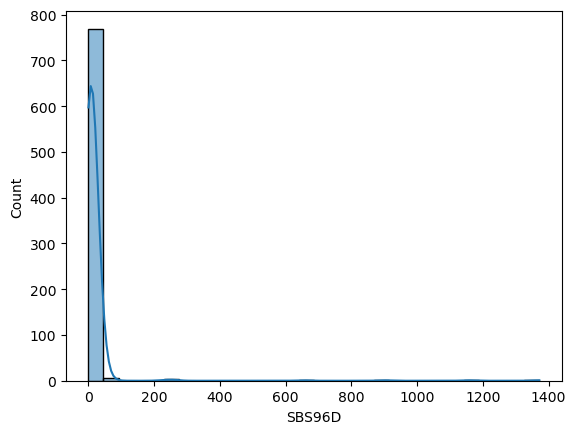

In [61]:
for col in X.columns:
    sns.histplot(X.loc[:,col], bins=30, kde=True)
    plt.show()

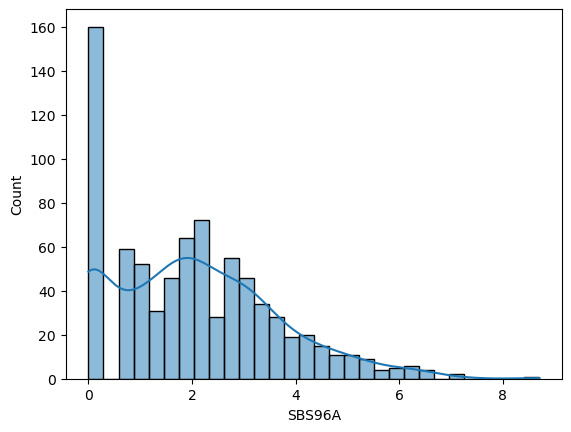

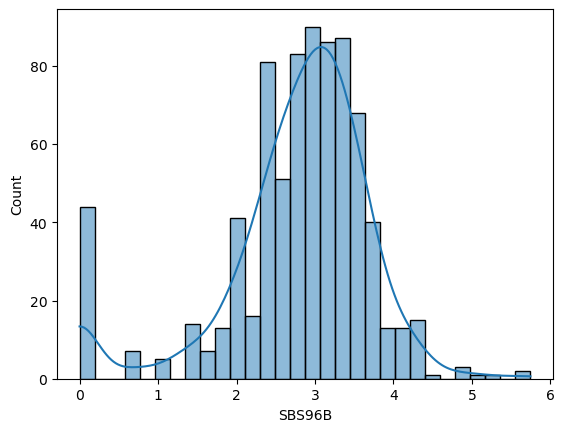

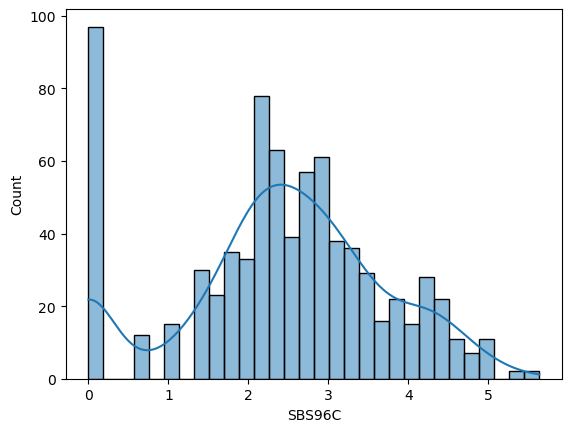

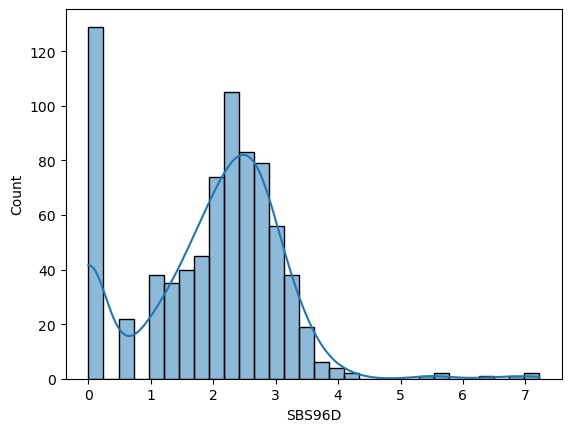

In [62]:
for col in X_log1p.columns:
    sns.histplot(X_log1p.loc[:,col], bins=30, kde=True)
    plt.show()

Text(0.5, 1.0, 'PFS > 5 years')

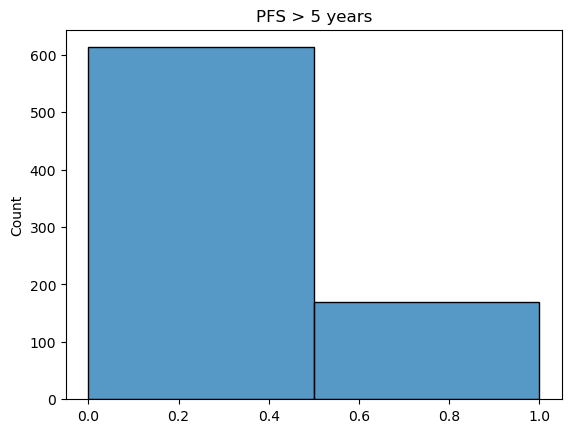

In [63]:
ax = sns.histplot(y, bins=2)
ax.set_title('PFS > 5 years')

<h1>Define filtering and evaluate models with 5-fold CV</h1>

In [64]:
def training_fold_filtering(X: pd.DataFrame, y: np.ndarray, k: int) -> tuple[pd.DataFrame, list[str]]:
    """
    Filtering logic should be implemented here. Then it will be applied to each cross validation training fold

    Takes in the DataFrame X and the list of target values y, applies filtering, and returns the filtered DataFrame and its column names (features)
        which will be used to subset the test fold data.

    Example filtering:
    1. Filter by mean expression
    2. Filter by variance
    3. Filter by within-class variance
    5. Select top k features using SelectKBest
    """
    X = DH.filter_genes_by_within_class_variance(X, y)

    if len(X.columns) < k:
        print(f"Warning: Less than {k} features after mean and variance filtering. Found {len(X.columns)} features.")
        print(f"Using all {len(X.columns)} features.")
        k = len(X.columns)

    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_genes = X.columns[selector.get_support()].tolist()
    return pd.DataFrame(X_new, columns=selected_genes, index=X.index), selected_genes

In [65]:
# evaluate models with different number of features
results = {}
for k in range(1, 5):
    print(f"Evaluating models with top {k} features...")
    results[k] = evaluate_models(X_log1p, y, filter_data=training_fold_filtering, k=k)

Evaluating models with top 1 features...
Evaluating models with top 2 features...
Evaluating models with top 3 features...
Evaluating models with top 4 features...


In [66]:
# find the top 4 models based on average of models' f1 score
f1_scores = []
result_k = []
for k, res in results.items():
    scores = []
    for name, model in res.items():
        scores.append(model['F1 Score']['global'])
    f1_scores.append(np.mean(scores))
    result_k.append(k)

# get the top 3 models
top_k = np.asarray(result_k)[np.argsort(f1_scores)[-3:][::-1]]

<h1>plot data</h1>

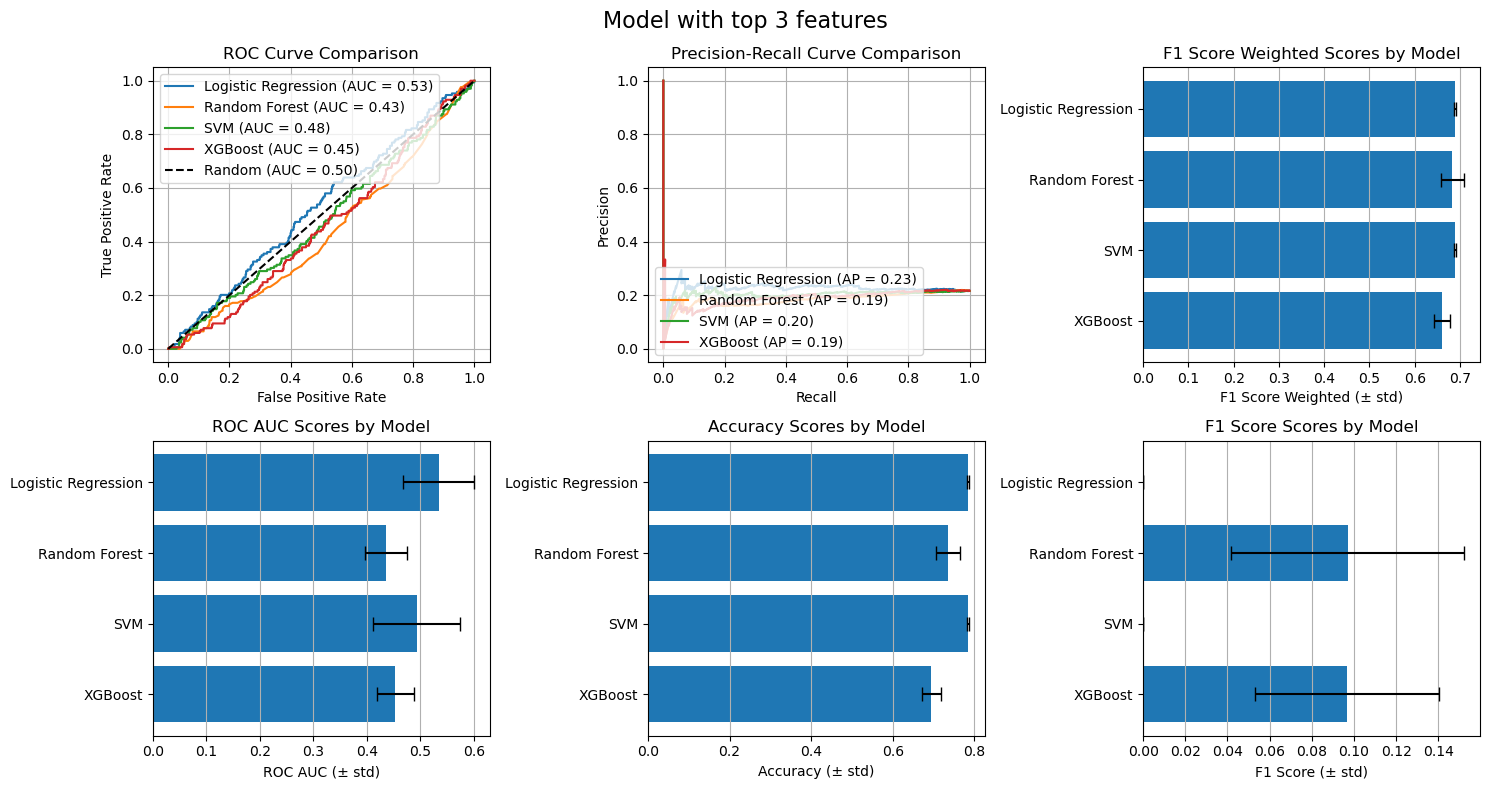

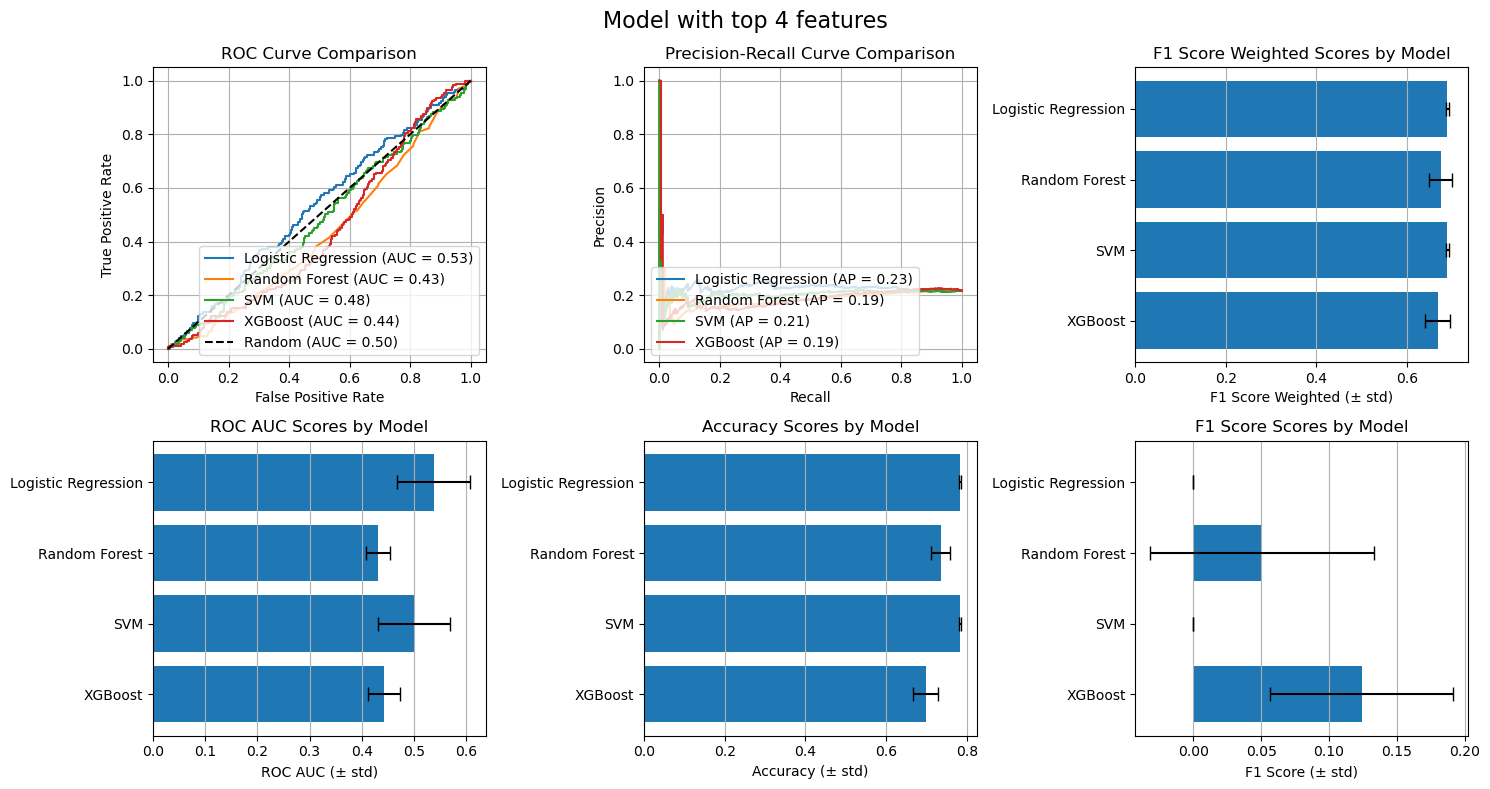

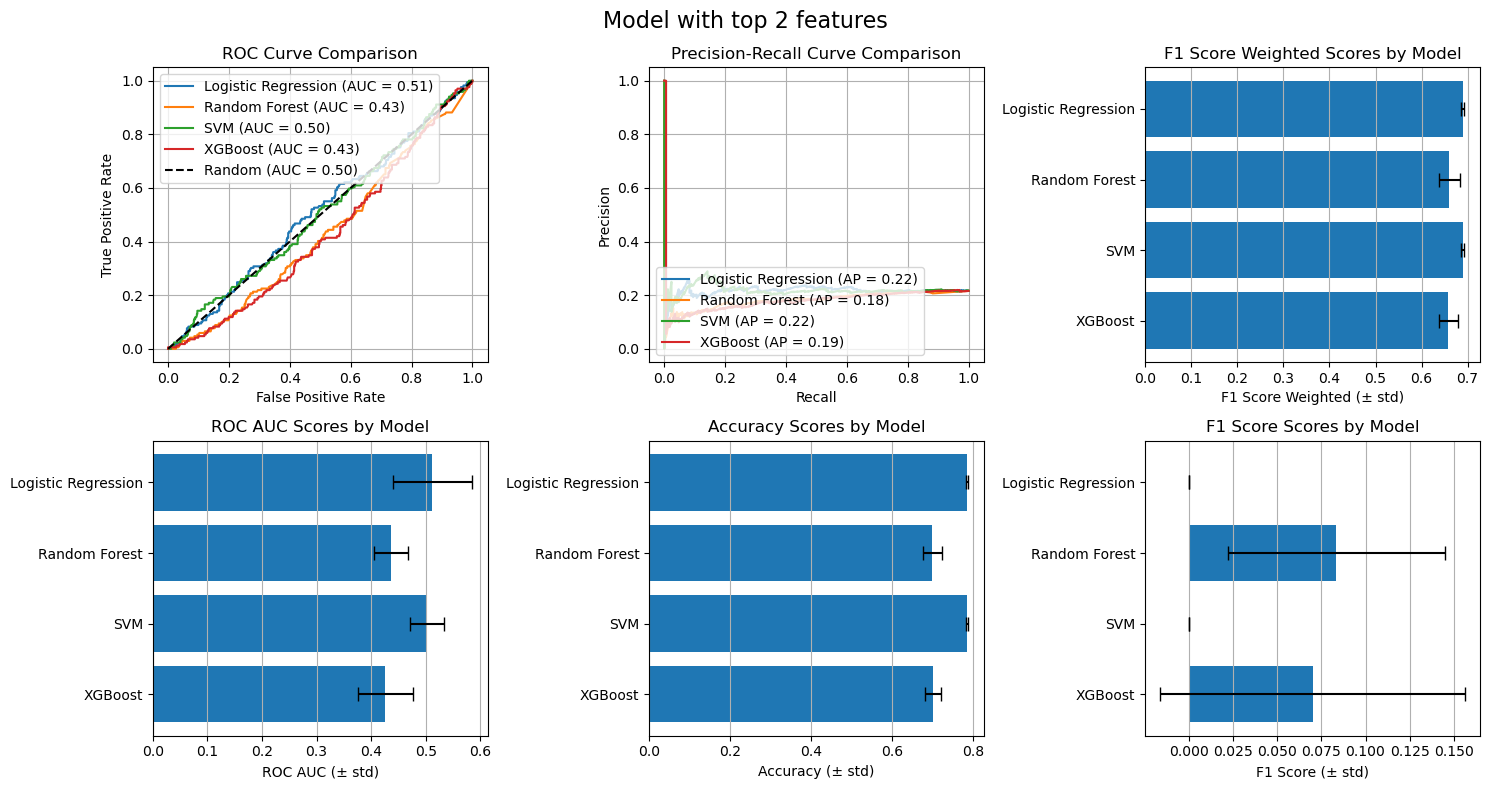

In [67]:
for k in top_k:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    plot_roc_curves(results[k], ax=axes[0, 0])
    plot_precision_recall_curves(results[k], ax=axes[0, 1])
    plot_classification_metric(results[k], ax=axes[0, 2], metric='F1 Score Weighted')
    plot_classification_metric(results[k], ax=axes[1, 0], metric='ROC AUC')
    plot_classification_metric(results[k], ax=axes[1, 1], metric='Accuracy')
    plot_classification_metric(results[k], ax=axes[1, 2], metric='F1 Score')
    fig.suptitle(f"Model with top {k} features", fontsize=16)
    fig.tight_layout()